### Cory Melendez
### Clustering Project
### 9/17/2020
### Github Link: https://github.com/cmelende/ClusteringProject.git

In [261]:
import pandas as pd
from univariateAnalysis import UniVariateAnalysis, UniVariateReport, OutlierFilter
from metrics import Metrics
from scipy.stats import zscore
import seaborn as sns
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans
import matplotlib.pylab as plt
import numpy as np
from sklearn.cluster import AgglomerativeClustering 
from scipy.cluster.hierarchy import cophenet, dendrogram, linkage
from scipy.spatial.distance import pdist  
from sklearn.metrics import silhouette_samples, silhouette_score

In [262]:
df = pd.read_excel("Credit Card Customer Data.xlsx")
all_cols = ['Sl_No','Customer Key','Avg_Credit_Limit','Total_Credit_Cards','Total_visits_bank','Total_visits_online','Total_calls_made']
def print_all_uni_analysis_reports(df,columnNames):
    seperator = '---------------------------------------------'
    for column in columnNames:
        analysis = UniVariateAnalysis(df, column)
        analysis_report = UniVariateReport(analysis)

        print(seperator)
        print(f'\'{column}\' column univariate analysis report')
        print(seperator)

        analysis_report.print_report()

In [263]:
df.head()

Sl_No  Customer Key  Avg_Credit_Limit  Total_Credit_Cards  \
0      1         87073            100000                   2   
1      2         38414             50000                   3   
2      3         17341             50000                   7   
3      4         40496             30000                   5   
4      5         47437            100000                   6   

   Total_visits_bank  Total_visits_online  Total_calls_made  
0                  1                    1                 0  
1                  0                   10                 9  
2                  1                    3                 4  
3                  1                    1                 4  
4                  0                   12                 3

In [264]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 660 entries, 0 to 659
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   Sl_No                660 non-null    int64
 1   Customer Key         660 non-null    int64
 2   Avg_Credit_Limit     660 non-null    int64
 3   Total_Credit_Cards   660 non-null    int64
 4   Total_visits_bank    660 non-null    int64
 5   Total_visits_online  660 non-null    int64
 6   Total_calls_made     660 non-null    int64
dtypes: int64(7)
memory usage: 36.2 KB


In [265]:
df.describe()

Sl_No  Customer Key  Avg_Credit_Limit  Total_Credit_Cards  \
count  660.000000    660.000000        660.000000          660.000000   
mean   330.500000  55141.443939      34574.242424            4.706061   
std    190.669872  25627.772200      37625.487804            2.167835   
min      1.000000  11265.000000       3000.000000            1.000000   
25%    165.750000  33825.250000      10000.000000            3.000000   
50%    330.500000  53874.500000      18000.000000            5.000000   
75%    495.250000  77202.500000      48000.000000            6.000000   
max    660.000000  99843.000000     200000.000000           10.000000   

       Total_visits_bank  Total_visits_online  Total_calls_made  
count         660.000000           660.000000        660.000000  
mean            2.403030             2.606061          3.583333  
std             1.631813             2.935724          2.865317  
min             0.000000             0.000000          0.000000  
25%             1.000000             1.000000          1.000000  
50%             2.000000             2.000000          3.000000  
75%             4.000000             4.000000          5.000000  
max             5.000000            15.000000         10.000000

In [266]:
# check to see if there are any NaN
df.isnull().values.any()

False

## 1. Univariate Analysis and Data Cleaning


#### The columns 'Avg_Credit_Limit', 'Total_visits_online' have several outliers. Ill create a df for later use to try out clustering without outliers. There are no categorical variables in the traditional sense, we could make the columns with low ranges ('Total_Credit_Cards', 'Total_visits_bank', 'Total_visits_online', 'Total_calls_made') into categorial variables by splitting them into n boolean columns where n = (max+1-min). But at this time, I dont see the need to do this. This would also in a real life scenario make our model more brittle, as new rows that have column values outside the current range would require additional work in order to maintain our model. 

As for scaling - we can see that all of the non 'total' columns are scaled quite differently than the other columns. Whereas, the 'total' columns range from 0-20, the other columns have a signficantly higher scale to them. We'll keep this in mind so these differences in scales doesnt affect our clustering in a negative way.

I'm not entirely sure what the 'Sl_No' is supposed to represent here, but I am assuming that it is a 'serial number' column. The 'Sl_No' along with the customer key column doesnt seem to really represent anything tangible that we would want to cluster off of, these values are mostly entirely system generated (based on the CIS system the bank uses). In a real world scenario, we would lean on business analysts and product people in order to gain a better understanding on what this means and what, if anything, information can be derived from these columns that would tell us more information about the customer. For now, I am going to remove this columsn when grabbing the scaled dataframes

In [267]:
print_all_uni_analysis_reports(df, all_cols)

---------------------------------------------
'Sl_No' column univariate analysis report
---------------------------------------------
Data type:  int64
Range of values: (1, 660)
Standard deviation:  190.66987176793296
Q1:  165.75
Q2:  330.5
Q3:  495.25
Q4:  660.0
Mean:  330.5
Min:  1
Median:  330.5
Max:  660
Top whisker:  989.5
Bottom whisker:  -328.5
Number of outliers above the top whisker:  0
Number of outliers below the bottom whisker:  0
---------------------------------------------
'Customer Key' column univariate analysis report
---------------------------------------------
Data type:  int64
Range of values: (11265, 99843)
Standard deviation:  25627.772200050316
Q1:  33825.25
Q2:  53874.5
Q3:  77202.5
Q4:  99843.0
Mean:  55141.44393939394
Min:  11265
Median:  53874.5
Max:  99843
Top whisker:  142268.375
Bottom whisker:  -31240.625
Number of outliers above the top whisker:  0
Number of outliers below the bottom whisker:  0
---------------------------------------------
'Avg_Credit

In [268]:
outlier_filter = OutlierFilter(df, all_cols)
df_no_outliers = outlier_filter.get_df_without_outliers()

In [269]:
df_no_outliers.head()

Sl_No  Customer Key  Avg_Credit_Limit  Total_Credit_Cards  \
0      1         87073            100000                   2   
2      3         17341             50000                   7   
3      4         40496             30000                   5   
5      6         58634             20000                   3   
7      8         37376             15000                   3   

   Total_visits_bank  Total_visits_online  Total_calls_made  
0                  1                    1                 0  
2                  1                    3                 4  
3                  1                    1                 4  
5                  0                    1                 8  
7                  0                    1                 1

In [270]:
df_no_outliers.describe()

Sl_No  Customer Key  Avg_Credit_Limit  Total_Credit_Cards  \
count  611.000000    611.000000        611.000000          611.000000   
mean   309.057283  54991.862520      26032.733224            4.391162   
std    176.674012  25552.363847      21054.003371            1.885889   
min      1.000000  11265.000000       3000.000000            1.000000   
25%    156.500000  33890.500000      10000.000000            3.000000   
50%    309.000000  53898.000000      17000.000000            4.000000   
75%    461.500000  76605.000000      39000.000000            6.000000   
max    644.000000  99596.000000     100000.000000            9.000000   

       Total_visits_bank  Total_visits_online  Total_calls_made  
count         611.000000           611.000000        611.000000  
mean            2.548282             1.929624          3.772504  
std             1.603953             1.588882          2.867963  
min             0.000000             0.000000          0.000000  
25%             1.000000             1.000000          1.000000  
50%             2.000000             2.000000          3.000000  
75%             4.000000             3.000000          6.000000  
max             5.000000             8.000000         10.000000

In [271]:
df_no_outliers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 611 entries, 0 to 643
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   Sl_No                611 non-null    int64
 1   Customer Key         611 non-null    int64
 2   Avg_Credit_Limit     611 non-null    int64
 3   Total_Credit_Cards   611 non-null    int64
 4   Total_visits_bank    611 non-null    int64
 5   Total_visits_online  611 non-null    int64
 6   Total_calls_made     611 non-null    int64
dtypes: int64(7)
memory usage: 38.2 KB


In [272]:
# Get scaled dataframes with and without outliers
df_customer_numbers_removed = df.iloc[:,2:]
df_customer_numbers_removed.head()

Avg_Credit_Limit  Total_Credit_Cards  Total_visits_bank  \
0            100000                   2                  1   
1             50000                   3                  0   
2             50000                   7                  1   
3             30000                   5                  1   
4            100000                   6                  0   

   Total_visits_online  Total_calls_made  
0                    1                 0  
1                   10                 9  
2                    3                 4  
3                    1                 4  
4                   12                 3

In [273]:
df_customer_numbers_removed_no_outliers = df_no_outliers.iloc[:,2:]
df_customer_numbers_removed_no_outliers.head()

Avg_Credit_Limit  Total_Credit_Cards  Total_visits_bank  \
0            100000                   2                  1   
2             50000                   7                  1   
3             30000                   5                  1   
5             20000                   3                  0   
7             15000                   3                  0   

   Total_visits_online  Total_calls_made  
0                    1                 0  
2                    3                 4  
3                    1                 4  
5                    1                 8  
7                    1                 1

In [274]:
df_scaled = df_customer_numbers_removed.apply(zscore)
df_scaled.head()

Avg_Credit_Limit  Total_Credit_Cards  Total_visits_bank  \
0          1.740187           -1.249225          -0.860451   
1          0.410293           -0.787585          -1.473731   
2          0.410293            1.058973          -0.860451   
3         -0.121665            0.135694          -0.860451   
4          1.740187            0.597334          -1.473731   

   Total_visits_online  Total_calls_made  
0            -0.547490         -1.251537  
1             2.520519          1.891859  
2             0.134290          0.145528  
3            -0.547490          0.145528  
4             3.202298         -0.203739

In [275]:
df_scaled_no_outliers = df_customer_numbers_removed_no_outliers.apply(zscore)
df_scaled_no_outliers.head()

Avg_Credit_Limit  Total_Credit_Cards  Total_visits_bank  \
0          3.516095           -1.268962          -0.966082   
2          1.139304            1.384480          -0.966082   
3          0.188587            0.323103          -0.966082   
5         -0.286771           -0.738273          -1.590053   
7         -0.524450           -0.738273          -1.590053   

   Total_visits_online  Total_calls_made  
0            -0.585560         -1.316473  
2             0.674218          0.079388  
3            -0.585560          0.079388  
5            -0.585560          1.475249  
7            -0.585560         -0.967508

## 2. Analysis
Using a pair plot, we'll take a look at each diagonal graph in order to try to grasp how many clusters we may need

### 'Avg_Credit_Limit': We can see a little bit of a difference between the data with and without outliers, the one without outliers doesnt have as large as a tail. Because of this, i would assume that the no outlier dataframe that we generated may be best here. At most, we'll have maybe 3, there may be two maximas on this graph that would suggest that 3 clusters would be needed.

### 'Total_Credit_Cards': Using the non outlier df, its easier to see that we will definately need 3 clusters, looking at the df with outliers, its much harder to tell and we would need up to 4.

### 'Total_visits_bank': We could probably get away with 3 clusters here, but it may be worth to try 4 as it looks like the last half of the non outlier graph has 2 maximas.

### 'Total_visits_online': Interestingly, the non outlier dataframe gives us some (perhaps better) signficantly different results. In the outlier df, we can see that we would need a maximum of 1 outlier, however the tail on that graph is quite significant which may cause our data to be skewed. If we look at the non outlier df, we can see that we can use at least 3 (maybe 4) clusters

### 'Total_calls_made': Not a whole lot if different between these two dataframes. We'll probably want at least 3 clusters for this graph.


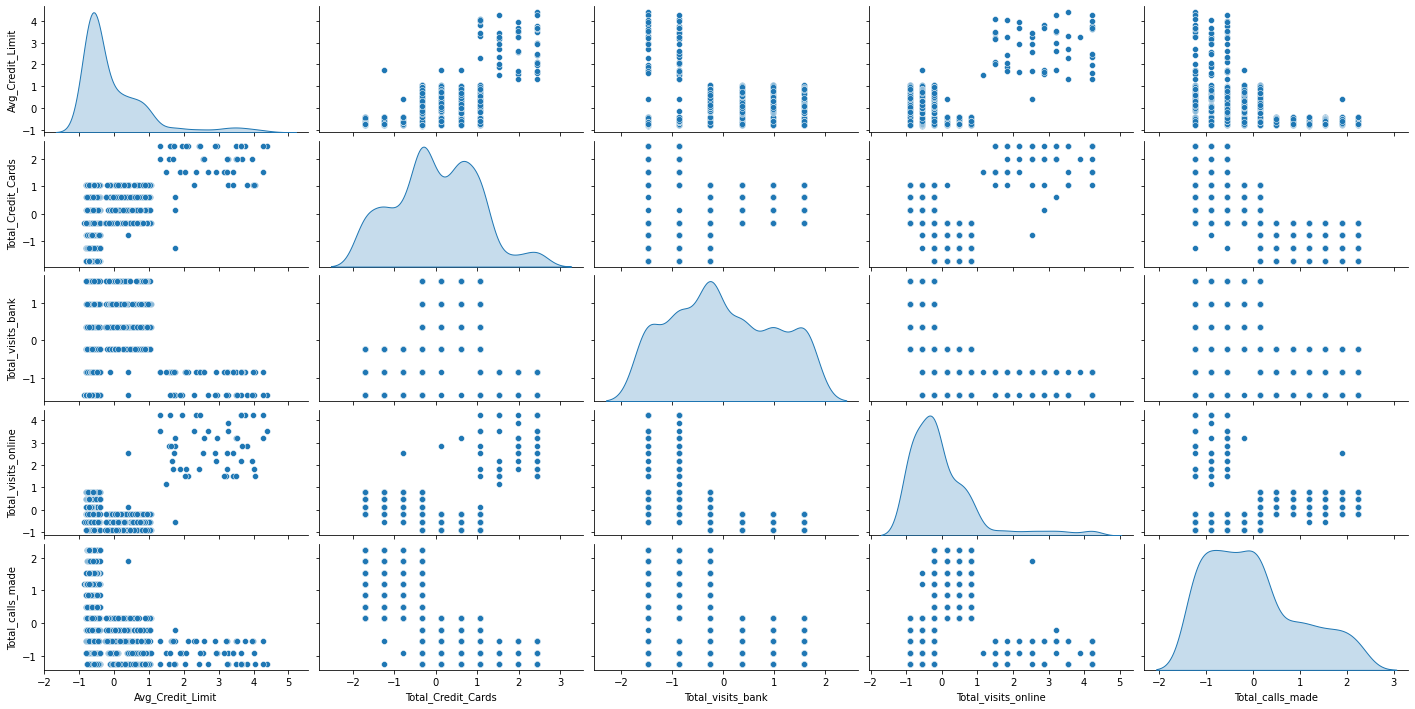

In [276]:
sns.pairplot(df_scaled, height=2, aspect=2, diag_kind='kde')

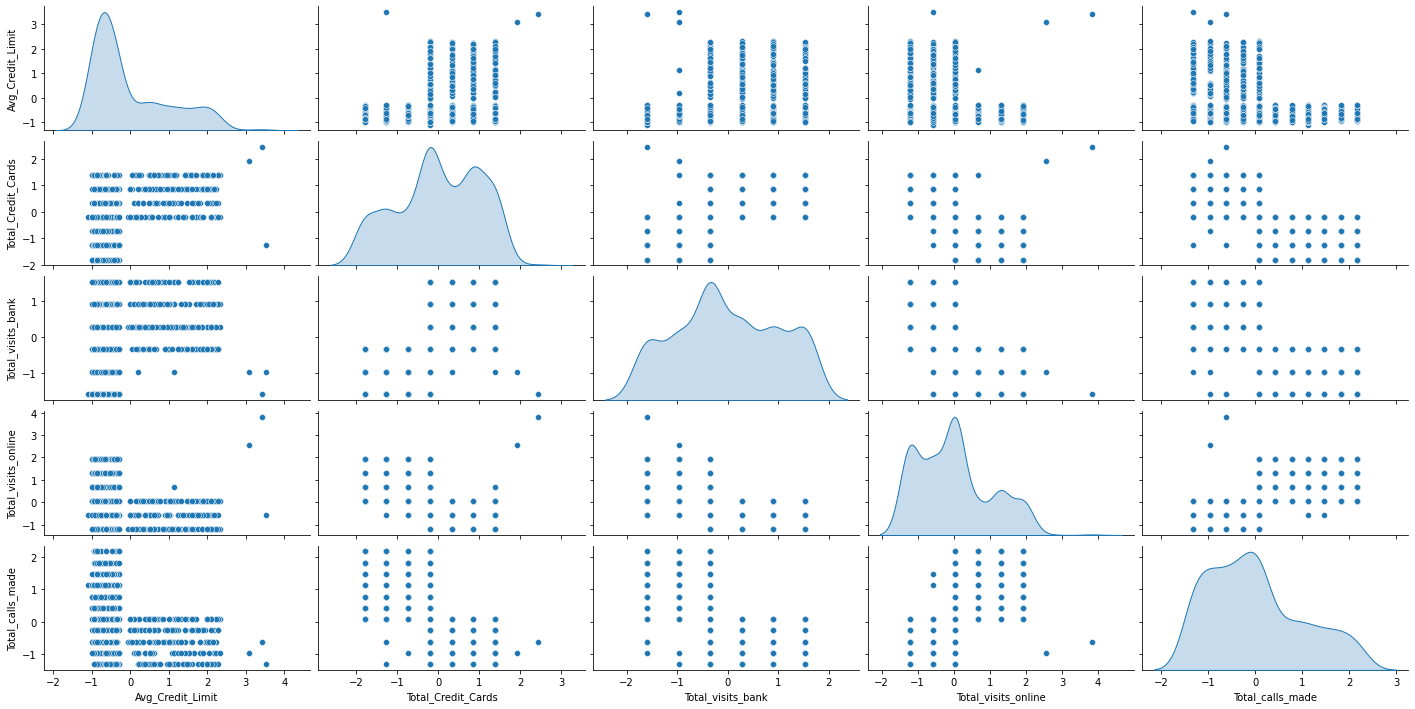

In [277]:
sns.pairplot(df_scaled_no_outliers, height=2, aspect=2, diag_kind='kde')

## 3. K-Means clustering

From previous analysis, lets check for the optimal number of clusters 1-5 since 4 is the most amount of clusters that we determined previously, we wont go much higher than that to check


In [278]:
number_of_clusters = [1,2,3,4,5]


def get_distortions(scaled_df, try_number_of_clusters):
    distortions = []
    for try_num in try_number_of_clusters:
        model = KMeans(n_clusters=try_num)
        model.fit(scaled_df)
        prediction = model.predict(scaled_df)
        distortions.append(sum(np.min(cdist(scaled_df, model.cluster_centers_, 'euclidean'), axis=1)) / scaled_df.shape[0])
    return distortions

Text(0.5, 1.0, 'Selecting k with the Elbow Method')

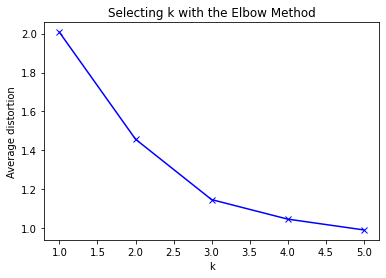

In [279]:
mean_distortions = get_distortions(df_scaled, number_of_clusters)

plt.plot(number_of_clusters, mean_distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Average distortion')
plt.title('Selecting k with the Elbow Method')

Text(0.5, 1.0, 'Selecting k with the Elbow Method')

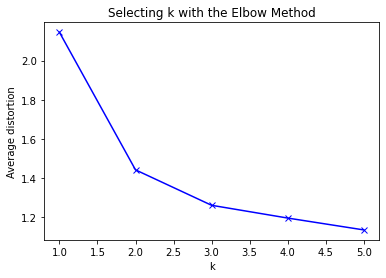

In [280]:
mean_distortions = get_distortions(df_scaled_no_outliers, number_of_clusters)

plt.plot(number_of_clusters, mean_distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Average distortion')
plt.title('Selecting k with the Elbow Method')

#### Either way, using the dataframe with or without outliers, we get about the same result. That is there is an elbow at 3.0 on either dataframe

In [281]:
group_col = 'Group'

In [282]:
k_means_model = KMeans(3)
k_means_model.fit(df_scaled_no_outliers)
prediction = k_means_model.predict(df_scaled_no_outliers)

cluster_labels = k_means_model.fit_predict(df_scaled_no_outliers)

df_scaled_no_outliers_with_group = df_scaled_no_outliers.copy()
df_scaled_no_outliers_with_group[group_col] = prediction
df_scaled_no_outliers_with_group.head(20)

Avg_Credit_Limit  Total_Credit_Cards  Total_visits_bank  \
0           3.516095           -1.268962          -0.966082   
2           1.139304            1.384480          -0.966082   
3           0.188587            0.323103          -0.966082   
5          -0.286771           -0.738273          -1.590053   
7          -0.524450           -0.738273          -1.590053   
8          -0.999808           -1.268962          -1.590053   
9          -1.094880           -0.207585          -1.590053   
10         -0.762129           -0.207585          -1.590053   
11         -0.619522           -0.738273          -1.590053   
12         -0.714593           -1.799650          -0.342111   
13         -0.809665           -1.799650          -0.966082   
14         -0.952272           -1.268962          -0.342111   
15         -0.857201           -1.268962          -1.590053   
16         -0.524450           -1.268962          -0.966082   
17         -0.857201           -1.268962          -1.590053   
18         -0.714593           -1.268962          -0.342111   
19         -0.334307           -0.207585          -0.966082   
20         -0.999808           -0.738273          -0.342111   
21         -0.476914           -1.268962          -1.590053   
22         -0.952272           -0.207585          -0.966082   

    Total_visits_online  Total_calls_made  Group  
0             -0.585560         -1.316473      0  
2              0.674218          0.079388      0  
3             -0.585560          0.079388      2  
5             -0.585560          1.475249      1  
7             -0.585560         -0.967508      2  
8              0.044329         -0.618542      1  
9             -0.585560          1.126284      1  
10             1.933996          0.428353      1  
11             0.044329          1.126284      1  
12             1.933996          1.824214      1  
13             1.933996          0.777319      1  
14             1.304107          0.777319      1  
15             1.933996          1.126284      1  
16             0.044329          0.079388      1  
17             0.674218          0.079388      1  
18             0.044329          1.126284      1  
19             1.933996          1.475249      1  
20             1.933996          0.428353      1  
21             0.674218          1.126284      1  
22             1.304107          0.777319      1

In [283]:
silhouette_avg = silhouette_score(df_scaled_no_outliers, cluster_labels)
print("The average silhouette_score for kmeans(3) :", silhouette_avg)

The average silhouette_score for kmeans(3) : 0.3761304224229804


In [284]:
df_scaled_no_outliers_cluster = df_scaled_no_outliers_with_group.groupby([group_col])
df_scaled_no_outliers_cluster.mean()

Avg_Credit_Limit  Total_Credit_Cards  Total_visits_bank  \
Group                                                            
0              1.486817            0.629650           0.413629   
1             -0.666412           -1.057647          -1.005610   
2             -0.402185            0.578019           0.679674   

       Total_visits_online  Total_calls_made  
Group                                         
0                -0.577735         -0.596867  
1                 1.016239          1.091545  
2                -0.574557         -0.633781

array([[<AxesSubplot:title={'center':'Avg_Credit_Limit'}, xlabel='[Group]'>,
        <AxesSubplot:title={'center':'Total_Credit_Cards'}, xlabel='[Group]'>,
        <AxesSubplot:title={'center':'Total_calls_made'}, xlabel='[Group]'>,
        <AxesSubplot:title={'center':'Total_visits_bank'}, xlabel='[Group]'>],
       [<AxesSubplot:title={'center':'Total_visits_online'}, xlabel='[Group]'>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

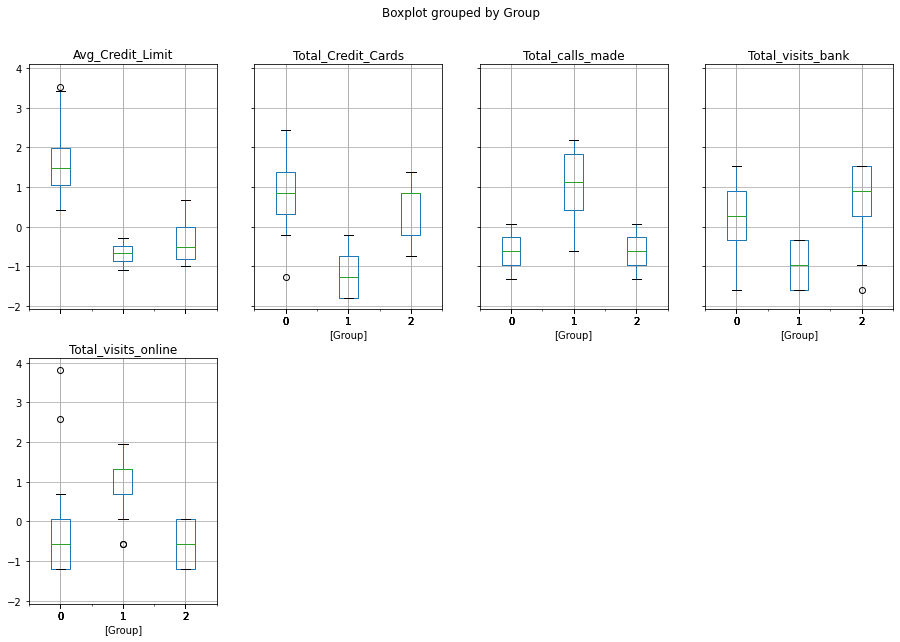

In [285]:
df_scaled_no_outliers_with_group.boxplot(by=group_col, layout=(2,4), figsize=(15,10))

#### Looking at the mean of our cluster there are a few things that we can derive

When looking at the total visits at the bank, online and calls made. There seems to be a inverse relationship between the three columns. That is, Group1  has the highest value of visits at the bank, but visits online and total calls made are low. Whereas, Group2 has high visits online and calls made but low average of totals visits at the bank. Group2 looks a lot like Group0

Keeping in mind the above statement, the difference between Group0 and Group2 is the average credit limit and the total number of credit cards seems to be close. So there may be some type of relationship or a centroid where if the customer has a higher amount of credit cards, they are more likely to to visit the bank in person versus calling or visiting the bank's website.

We can also see the data points cluster around certain average credit card limits that looks to be somewhat dependent on total credit cards, though as the total number of credit card increases, there is not a large increase in average credit limit, but the trend does seem to be there.



## 4. Hierarchical Clustering

In [286]:
avg_clustering = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='average')
avg_clustering.fit(df_scaled_no_outliers)
avg_clustering_labels = avg_clustering.fit_predict(df_scaled_no_outliers)

complete_clustering = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='complete')
complete_clustering.fit(df_scaled_no_outliers)
complete_clustering_labels = complete_clustering.fit_predict(df_scaled_no_outliers)

ward_clustering = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage="ward")
ward_clustering.fit(df_scaled_no_outliers)
ward_clustering_labels = ward_clustering.fit_predict(df_scaled_no_outliers)

In [287]:
labels = 'labels'

df_scaled_no_outliers_with_avg_cluster_labels = df_scaled_no_outliers.copy()
df_scaled_no_outliers_with_avg_cluster_labels[labels] = avg_clustering.labels_

df_scaled_no_outliers_with_complete_cluster_labels = df_scaled_no_outliers.copy()
df_scaled_no_outliers_with_complete_cluster_labels[labels] = complete_clustering.labels_

df_scaled_no_outliers_with_ward_cluster_labels =  df_scaled_no_outliers.copy()
df_scaled_no_outliers_with_ward_cluster_labels[labels] = ward_clustering.labels_

#### Average method

In [288]:
avg_sil_score = silhouette_score(df_scaled_no_outliers, avg_clustering_labels)
print("The average silhouette_score for hierarchical (average) :", avg_sil_score)

The average silhouette_score for hierarchical (average) : 0.34655119403522955


In [289]:
df_scaled_no_outliers_with_avg_cluster_labels.groupby([labels]).mean()

Avg_Credit_Limit  Total_Credit_Cards  Total_visits_bank  \
labels                                                            
0              -0.016489           -0.005086           0.005793   
1               3.254648            2.180512          -1.278067   
2               3.516095           -1.268962          -0.966082   

        Total_visits_online  Total_calls_made  
labels                                         
0                 -0.009543          0.004774  
1                  3.193774         -0.793025  
2                 -0.585560         -1.316473

In [290]:
Z = linkage(df_scaled_no_outliers, metric='euclidean', method='average')
c, coph_distances = cophenet(Z, pdist(df_scaled_no_outliers))

c

0.8312295289172809

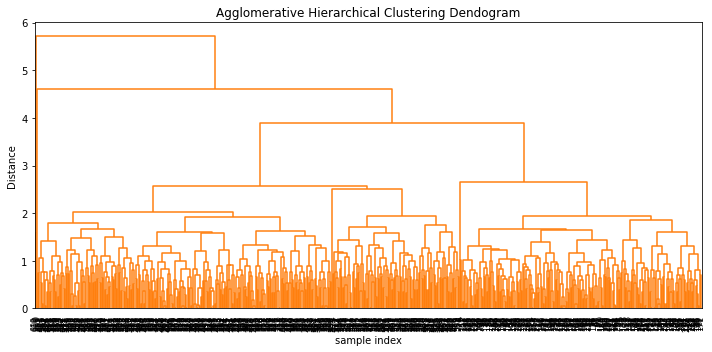

In [291]:
plt.figure(figsize=(10, 5))
plt.title('Agglomerative Hierarchical Clustering Dendogram')
plt.xlabel('sample index')
plt.ylabel('Distance')
dendrogram(Z, leaf_rotation=90.,color_threshold = 40, leaf_font_size=8. )
plt.tight_layout()

array([[<AxesSubplot:title={'center':'Avg_Credit_Limit'}, xlabel='[labels]'>,
        <AxesSubplot:title={'center':'Total_Credit_Cards'}, xlabel='[labels]'>,
        <AxesSubplot:title={'center':'Total_calls_made'}, xlabel='[labels]'>,
        <AxesSubplot:title={'center':'Total_visits_bank'}, xlabel='[labels]'>],
       [<AxesSubplot:title={'center':'Total_visits_online'}, xlabel='[labels]'>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

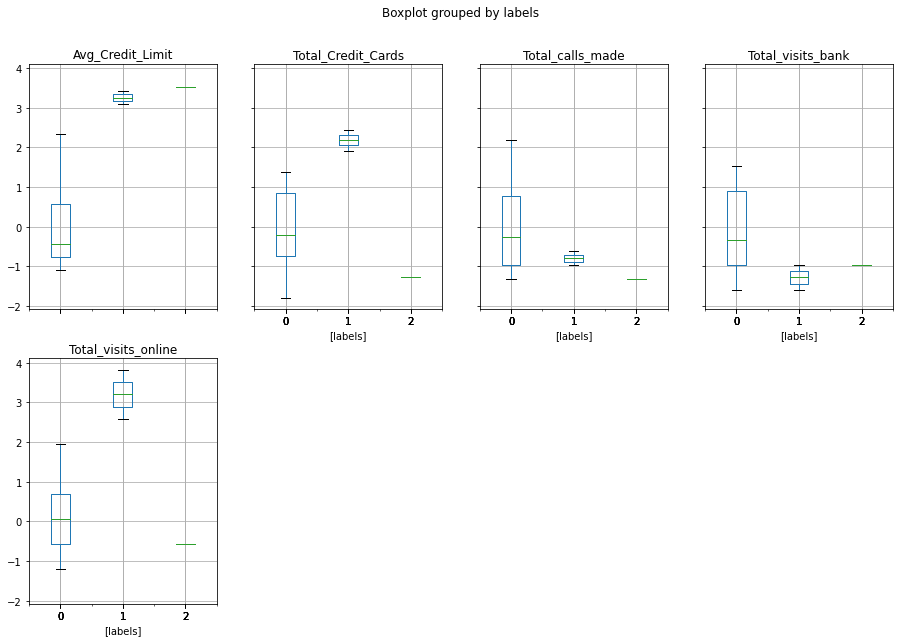

In [292]:
df_scaled_no_outliers_with_avg_cluster_labels.boxplot(by=labels, layout=(2,4), figsize=(15,10))

#### Complete method

In [293]:
complete_sil_score = silhouette_score(df_scaled_no_outliers, complete_clustering_labels)
print("The average silhouette_score for hierarchical (complete) :", complete_sil_score)

The average silhouette_score for hierarchical (complete) : 0.4811963046129657


In [294]:
df_scaled_no_outliers_with_complete_cluster_labels.groupby([labels]).mean()

Avg_Credit_Limit  Total_Credit_Cards  Total_visits_bank  \
labels                                                            
0               0.365096            0.594618           0.584976   
1               3.254648            2.180512          -1.278067   
2              -0.665773           -1.056208          -1.008242   

        Total_visits_online  Total_calls_made  
labels                                         
0                 -0.595325         -0.616739  
1                  3.193774         -0.793025  
2                  1.009024          1.082270

In [295]:
Z = linkage(df_scaled_no_outliers, metric='euclidean', method='complete')
c, coph_distances = cophenet(Z, pdist(df_scaled_no_outliers))

c

0.8162425103590711

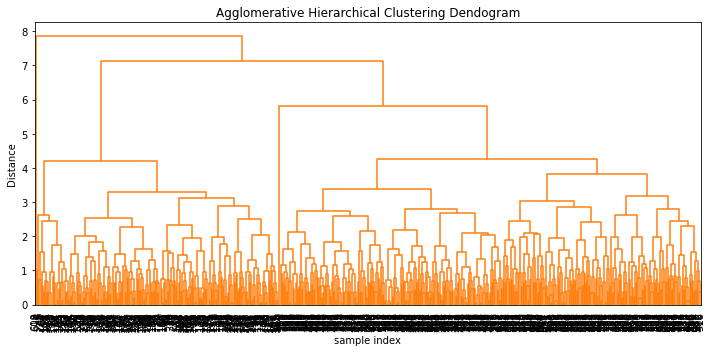

In [296]:
plt.figure(figsize=(10, 5))
plt.title('Agglomerative Hierarchical Clustering Dendogram')
plt.xlabel('sample index')
plt.ylabel('Distance')
dendrogram(Z, leaf_rotation=90.,color_threshold=90,  leaf_font_size=10. )
plt.tight_layout()

array([[<AxesSubplot:title={'center':'Avg_Credit_Limit'}, xlabel='[labels]'>,
        <AxesSubplot:title={'center':'Total_Credit_Cards'}, xlabel='[labels]'>,
        <AxesSubplot:title={'center':'Total_calls_made'}, xlabel='[labels]'>,
        <AxesSubplot:title={'center':'Total_visits_bank'}, xlabel='[labels]'>],
       [<AxesSubplot:title={'center':'Total_visits_online'}, xlabel='[labels]'>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

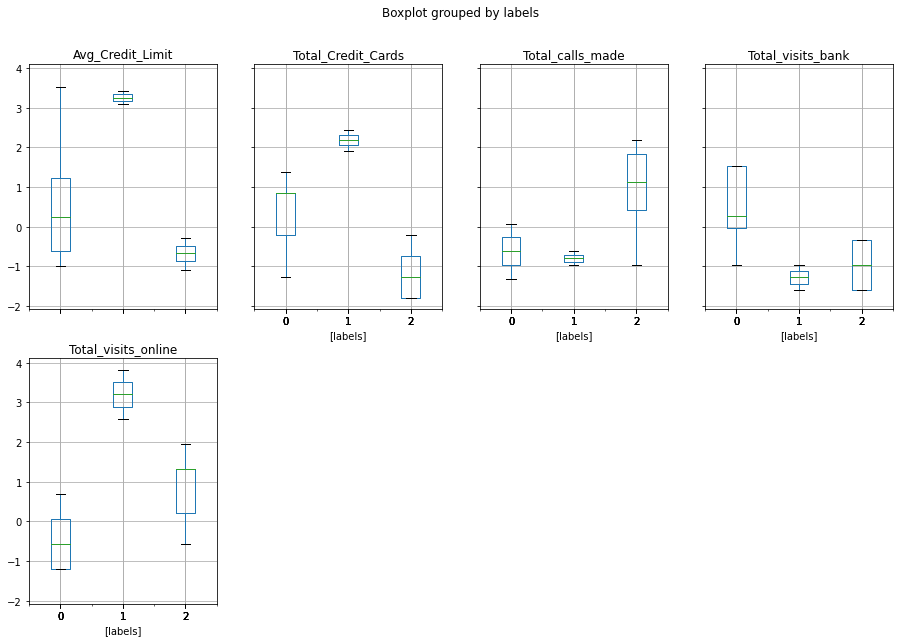

In [297]:
df_scaled_no_outliers_with_complete_cluster_labels.boxplot(by=labels, layout=(2,4), figsize=(15,10))

#### Ward method

In [298]:
ward_sil_score = silhouette_score(df_scaled_no_outliers, complete_clustering_labels)
print("The average silhouette_score for hierarchical (ward) :", ward_sil_score)

The average silhouette_score for hierarchical (ward) : 0.4811963046129657


In [299]:
df_scaled_no_outliers_with_ward_cluster_labels.groupby([labels]).mean()

Avg_Credit_Limit  Total_Credit_Cards  Total_visits_bank  \
labels                                                            
0               1.182260            0.632266           0.510839   
1              -0.665773           -1.056208          -1.008242   
2              -0.642873            0.565172           0.657701   

        Total_visits_online  Total_calls_made  
labels                                         
0                 -0.571113         -0.610539  
1                  1.009024          1.082270  
2                 -0.581876         -0.626705

In [300]:
Z = linkage(df_scaled_no_outliers, metric='euclidean', method='ward')
c, coph_dists = cophenet(Z , pdist(df_scaled_no_outliers))

c

0.7946519309058675

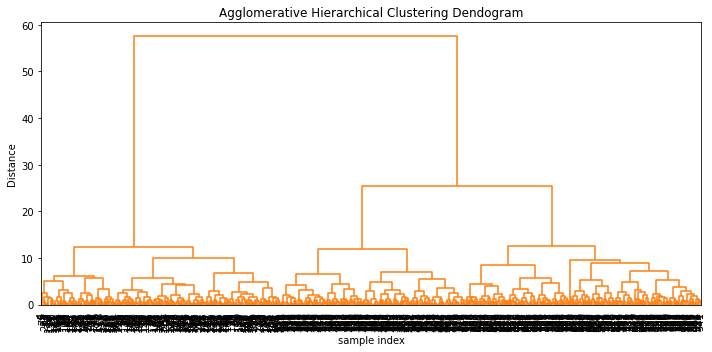

In [301]:
plt.figure(figsize=(10, 5))
plt.title('Agglomerative Hierarchical Clustering Dendogram')
plt.xlabel('sample index')
plt.ylabel('Distance')
dendrogram(Z, leaf_rotation=90.,color_threshold=600,  leaf_font_size=10. )
plt.tight_layout()

array([[<AxesSubplot:title={'center':'Avg_Credit_Limit'}, xlabel='[labels]'>,
        <AxesSubplot:title={'center':'Total_Credit_Cards'}, xlabel='[labels]'>,
        <AxesSubplot:title={'center':'Total_calls_made'}, xlabel='[labels]'>,
        <AxesSubplot:title={'center':'Total_visits_bank'}, xlabel='[labels]'>],
       [<AxesSubplot:title={'center':'Total_visits_online'}, xlabel='[labels]'>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

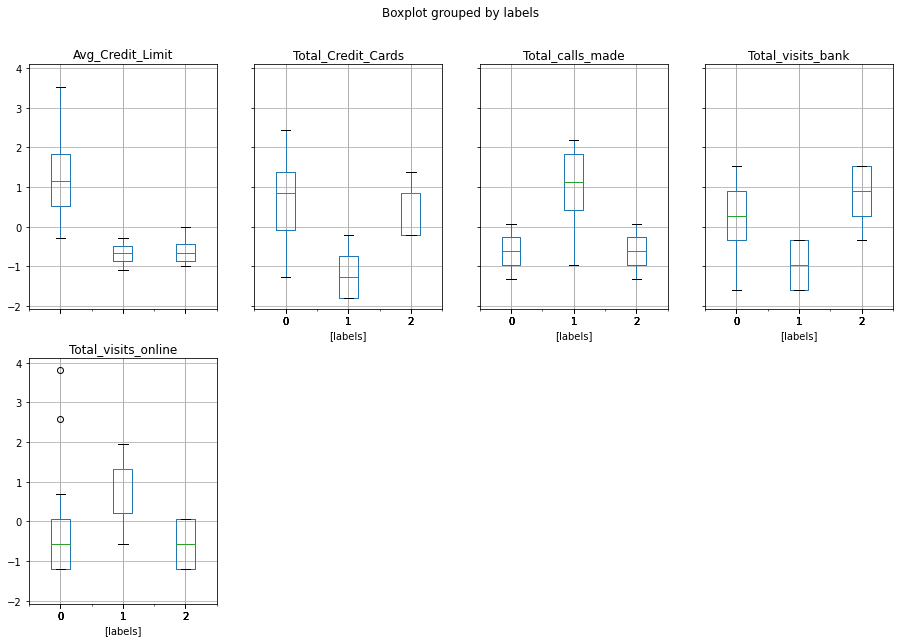

In [302]:
df_scaled_no_outliers_with_ward_cluster_labels.boxplot(by=labels, layout=(2,4), figsize=(15,10))

### 6. KMeans vs Hierarchical


KMeans and Hierarchical (ward) look similar, all of the 'total' boxplots of their clusters look almost identical. The only thing that differs is the Avg credit limit

Hierachical (complete) and Hierachical (average) look similar to each other, the only difference looks to be the spread of the datapoints are from the centroid. 

### 7. 

The Hierarchical (average) and Hierarchical (complete), according to their boxplots, have smaller 'boxes' which means that the range of the distance from each point to the centroid is much smaller

Like stated above, KMeans and Hierarchical (ward) are similar, they differ from the other two Hierarchical methods in that the range of the distance from each point to the centroid is bigger than the Hierarchical (average) and the Hierarchical (complete)

Additionally, KMeans and Hierarchical (ward) clusters seems to be distributed more evenly across all columns. We can see according to the box plot that the boxes are closer in size to the other boxes in each column. Meaning that the range (or we can think of it as a 'spread') of the distances from each point to the centroid are more congruent to the other groups in that column. Whereas, the Hierarchical (average) and Hierarchical (complete) have some very large boxes (spread) in some of the columns while the other groups of that column are more concentrated around the centroid (low spread)


